### 20190607 flow data

In [2]:
import fcsparser

import pandas as pd
import math
import os
#import all data, and merge into a single datatframe, with sample names in extra columns


def log_trans(x):
    try:
        return math.log(x, 10)
    except:
        return float('NaN')

data_folder = 'screen_validation_flow'

#collect guide names from plate layout data
layout_file = open('CRISPR_knockdown_flow_transfection_layout.txt')
guide_numbers = []
sample_dict = {}
guides = []
genes = []
for line in layout_file.readlines():
    number, gene, guide_num = line.strip().split('\t')[:3]
    sample_dict[int(number)] = [gene, guide_num]
    guides.append(gene + '_' + guide_num)
    genes.append(gene)
layout_file.close()

#will only look at data gated on good scatter
cell_lines = ['cBZ056', 'cBZ058', 'cBZ072']
stop_codons = ['UGAC', 'AQP4', 'UGGC']
dfs = []
stop_codon_index = 0
sample_index = 1
for cell_line in cell_lines:
    for guide_index in range(1, len(guides)+1):
        data_file_name = 'export_%s_tdTomato_tagBFP_%03d_%03d_FSC_single.fcs' % (cell_line, guide_index, sample_index)
        data_file_path = os.path.join(data_folder, data_file_name)
        meta, data = fcsparser.parse(data_file_path, meta_data_only=False, reformat_meta=True)
        data['gene'] = sample_dict[guide_index][0]
        guide = '%s_%s' % (sample_dict[guide_index][0], sample_dict[guide_index][1])
        data['guide'] = guide
        data['guide number'] = sample_dict[guide_index][1]
        data['cell line'] = cell_line
        data['stop codon'] = stop_codons[stop_codon_index]
        data['sample'] = '%s_%s' % (stop_codons[stop_codon_index], guide)
        #dfs.append(data.sample(n=1000)) 
        dfs.append(data) #to subsample and speed up plotting, use the above line instead of this one
        sample_index+=1
    stop_codon_index += 1
all_data = pd.concat(dfs)
all_data = all_data.rename(index=str, columns={'PE-A':'tdTomato-A', 'Pacific Blue-A':'tagBFP-A'})
all_data['tdTomato/tagBFP'] = all_data['tdTomato-A']/all_data['tagBFP-A']
all_data['log tdTomato'] = all_data['tdTomato-A'].apply(log_trans)
all_data['log tagBFP'] = all_data['tagBFP-A'].apply(log_trans)
all_data['log tdTomato/tagBFP'] = all_data['tdTomato/tagBFP'].apply(log_trans)

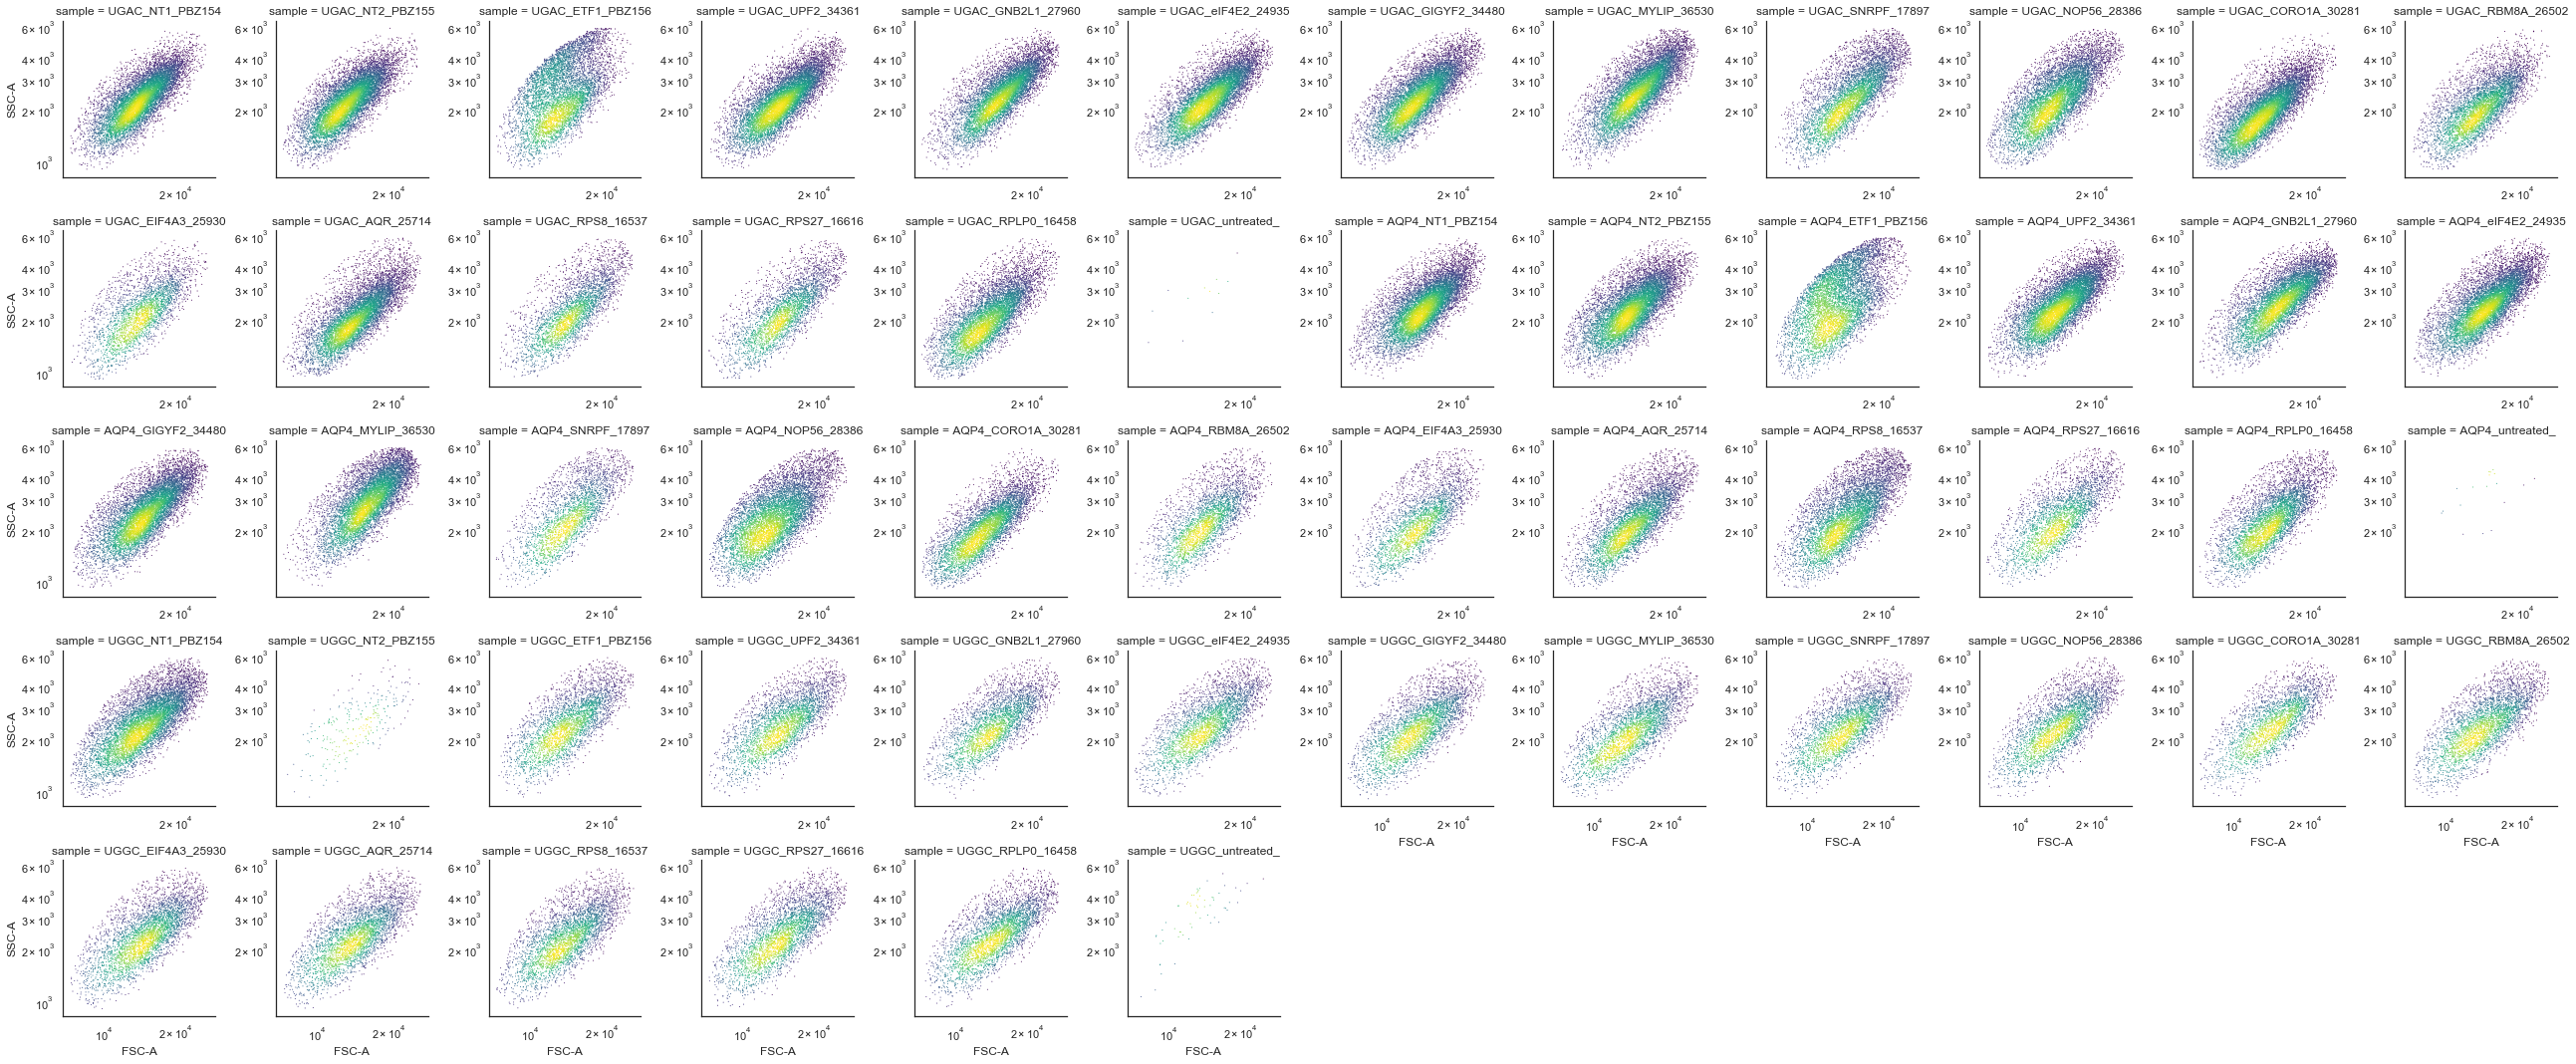

In [10]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import numpy as np
sns.set(style="white", color_codes=True)
def density_colored_scatter(x, y, color, **kwargs):
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    plt.scatter(x, y, c=z, **kwargs)
    plt.yscale('log')
    plt.xscale('log')
    #cutoff = 400
    #pos = [xval for xval in x if xval>=cutoff]
    #percent_pos = 100.*len(pos)/len(x)
    #plt.vlines(cutoff,1,1000000, linestyle='dashed')
    #plt.annotate("%.1f" % percent_pos, xy=(cutoff+1, 500000))
    
#xlim=(1,1000000),ylim=(1,1000000)
g = sns.FacetGrid(all_data, col="sample", col_wrap=12)

cmap = 'viridis'
g= g.map(density_colored_scatter, "FSC-A", "SSC-A", cmap=cmap, s=1, linewidth=0)
plt.savefig('20190607_FSC_SSC_A.pdf', transparent=True)
plt.savefig('20190607_FSC_SSC_A.png', transparent=True)

In [3]:
grouped_data = all_data.groupby(['stop codon', 'gene'])

In [4]:
#colors - colorblind safe
black = (0,0,0)
gray = (0.6,0.6,0.6)
orange = (230/255.0,159/255.0,0)
skyBlue = (86/255.0,180/255.0,233/255.0)
bluishGreen = (0,158/255.0,115/255.0)
yellow = (240/255.0,228/255.0,66/255.0)
blue = (0,114/255.0,178/255.0)
vermillion = (213/255.0,94/255.0,0)
reddishPurple = (204/255.0,121/255.0,167/255.0)
colors = [black, vermillion, orange, skyBlue, bluishGreen, blue, reddishPurple, yellow, gray]

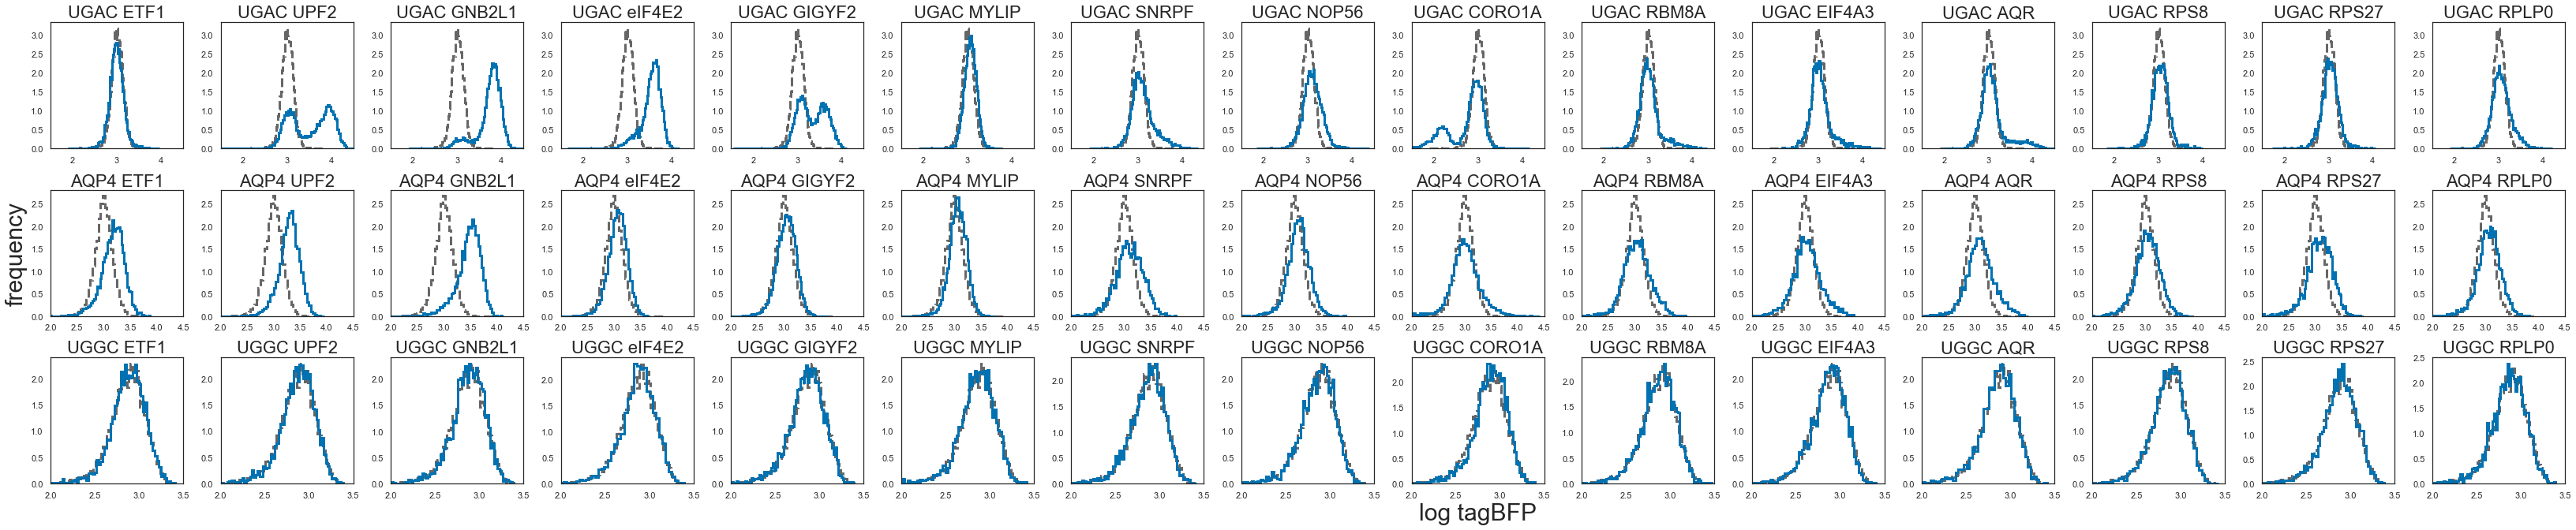

In [62]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 15
num_plots_high = 3

x_var='log tagBFP'
#y_var='tdTomato-A'
plot_index =1
fig = plt.figure(figsize=(3*num_plots_wide, 3*num_plots_high))
for stop_codon in stop_codons:
    for gene in genes[2:-1]:
        plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
        plots.append(plot)
        nt1_data = grouped_data.get_group((stop_codon, 'NT1'))
        #nt2_data = grouped_data.get_group((stop_codon, 'NT2'))
        nt1_data[x_var].plot.hist(color=black, histtype='step', bins=100, normed=True, linestyle='--', alpha=0.6, ax=plot, lw=3)
        #nt2_data[x_var].plot.hist(color=black, histtype='step', bins=100, normed=True, linestyle=':', alpha=0.6, ax=plot, lw=3)
        guide_data = grouped_data.get_group((stop_codon, gene))
        guide_data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=blue, alpha=1, ax=plot, lw=3)
        plot.set_title('%s %s'% (stop_codon, gene), fontsize=22)
        plot.set_xlabel('', fontsize=1)
        plot.set_ylabel('', fontsize=1)
        #plot.set_ylabel(y_var)
        #lot.set_xlim(xmin, xmax)
        if stop_codon == 'UGAC':
            plot.set_xlim(1.5, 4.5)
        elif stop_codon == 'AQP4':
            plot.set_xlim(2, 4.5)
        elif stop_codon == 'UGGC':
            plot.set_xlim(2, 3.5)
        guide_index+=1
        plot_index += 1
plt.tight_layout()
plots[38].set_xlabel(x_var, fontsize=30)
plots[15].set_ylabel('frequency', fontsize=30)
plt.savefig('20190607_log_tagBFP_hist.pdf', transparent=True)

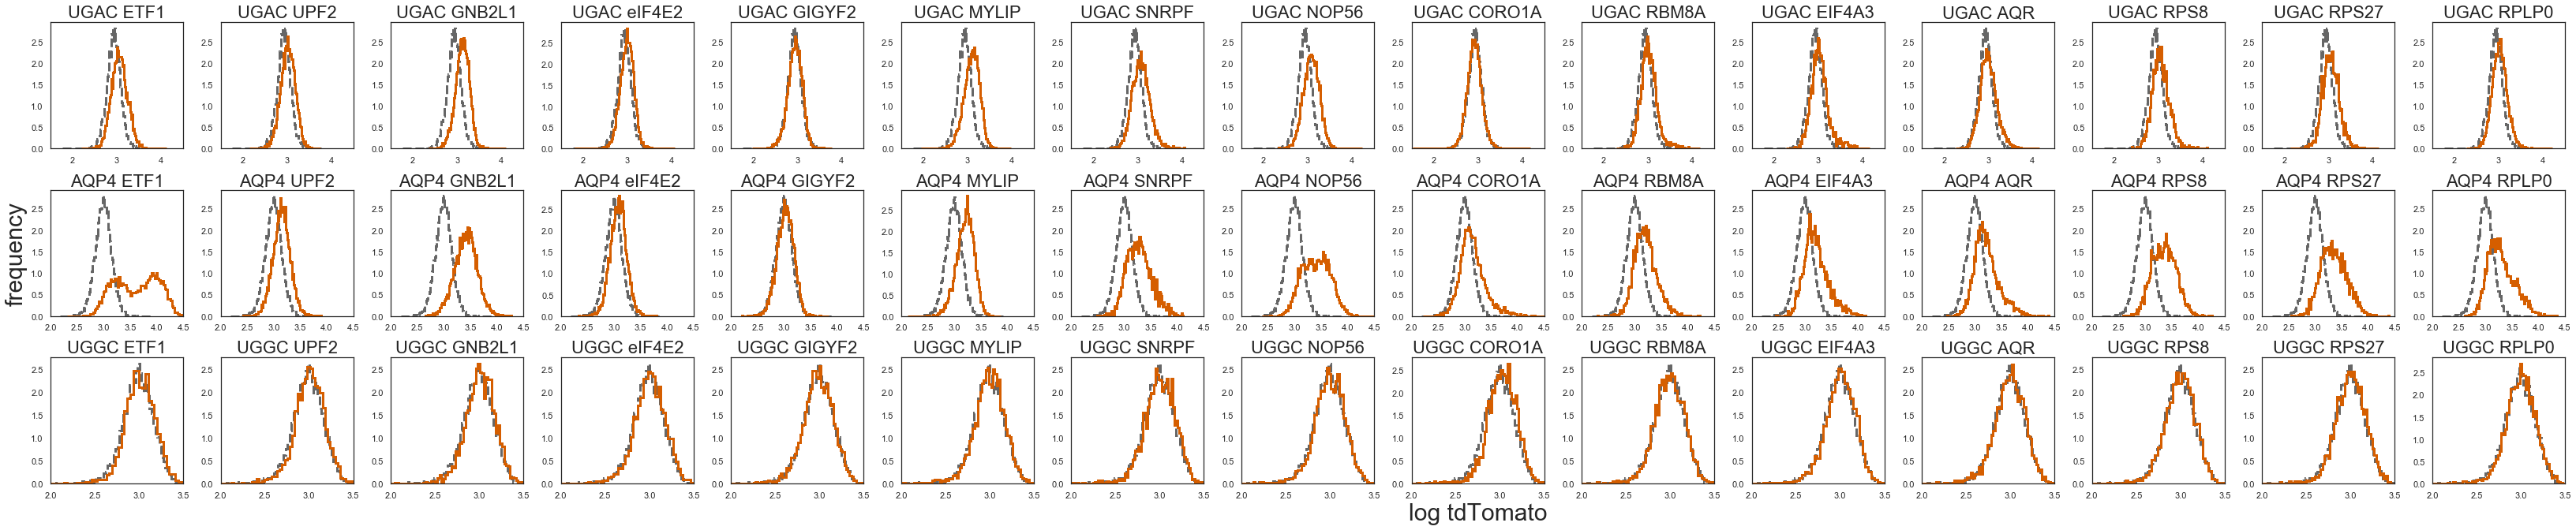

In [63]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 15
num_plots_high = 3

x_var='log tdTomato'
#y_var='tdTomato-A'
plot_index =1
fig = plt.figure(figsize=(3*num_plots_wide, 3*num_plots_high))
for stop_codon in stop_codons:
    for gene in genes[2:-1]:
        plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
        plots.append(plot)
        nt1_data = grouped_data.get_group((stop_codon, 'NT1'))
        #nt2_data = grouped_data.get_group((stop_codon, 'NT2'))
        nt1_data[x_var].plot.hist(color=black, histtype='step', bins=100, normed=True, linestyle='--', alpha=0.6, ax=plot, lw=3)
        #nt2_data[x_var].plot.hist(color=black, histtype='step', bins=100, normed=True, linestyle=':', alpha=0.6, ax=plot, lw=3)
        guide_data = grouped_data.get_group((stop_codon, gene))
        guide_data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=vermillion, alpha=1, ax=plot, lw=3)
        plot.set_title('%s %s'% (stop_codon, gene), fontsize=22)
        plot.set_xlabel('', fontsize=1)
        plot.set_ylabel('', fontsize=1)
        #plot.set_ylabel(y_var)
        #lot.set_xlim(xmin, xmax)
        if stop_codon == 'UGAC':
            plot.set_xlim(1.5, 4.5)
        elif stop_codon == 'AQP4':
            plot.set_xlim(2, 4.5)
        elif stop_codon == 'UGGC':
            plot.set_xlim(2, 3.5)
        guide_index+=1
        plot_index += 1
plt.tight_layout()
plots[38].set_xlabel(x_var, fontsize=30)
plots[15].set_ylabel('frequency', fontsize=30)
plt.savefig('20190607_log_tdTomato_hist.pdf', transparent=True)

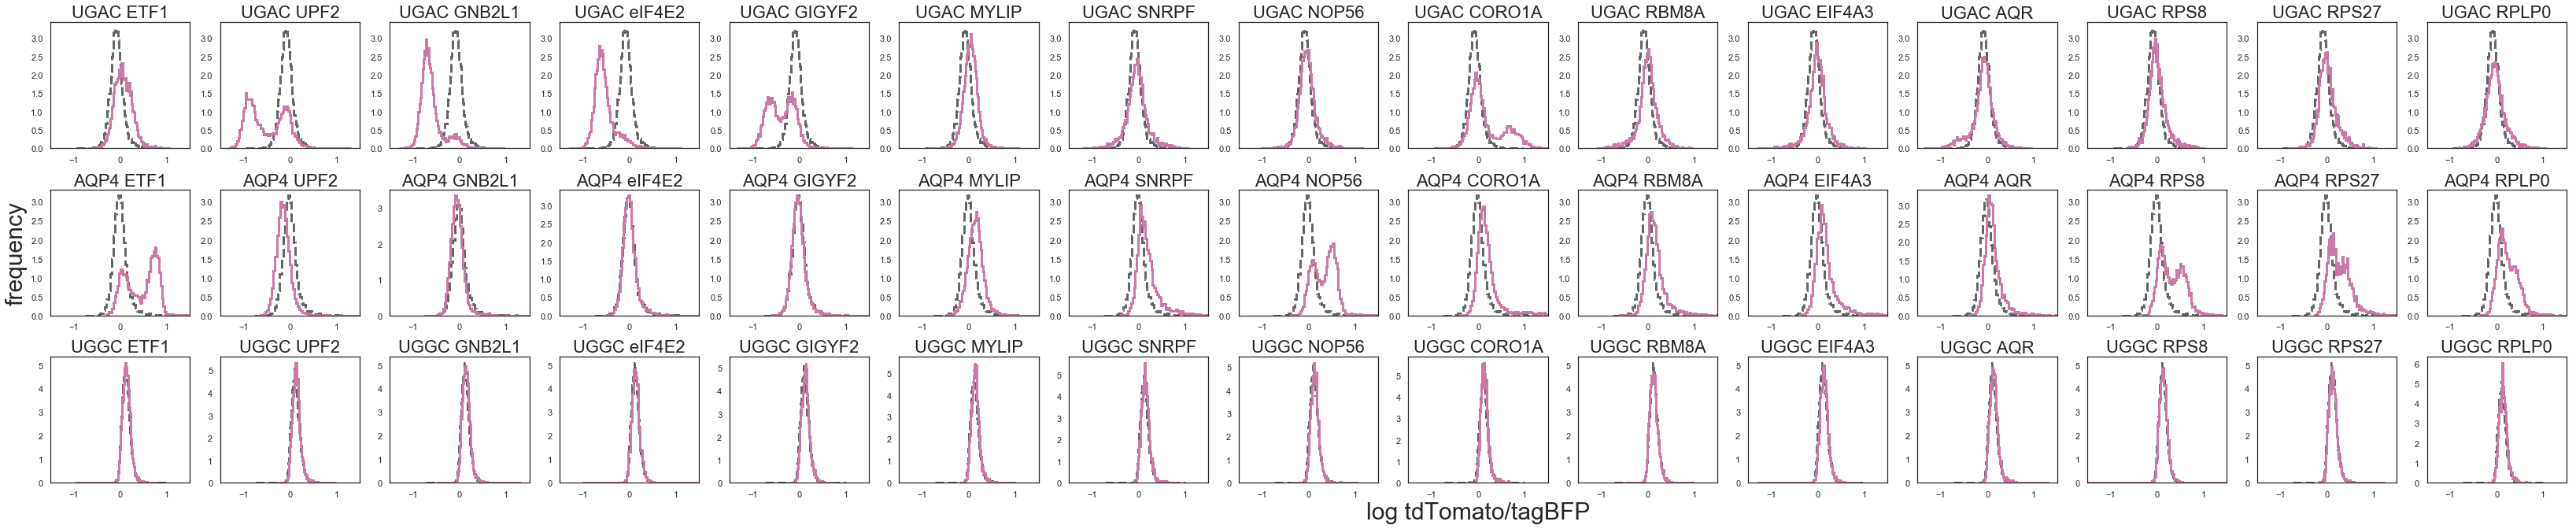

In [64]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 15
num_plots_high = 3

x_var='log tdTomato/tagBFP'
#y_var='tdTomato-A'
plot_index =1
fig = plt.figure(figsize=(3*num_plots_wide, 3*num_plots_high))
for stop_codon in stop_codons:
    for gene in genes[2:-1]:
        plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
        plots.append(plot)
        nt1_data = grouped_data.get_group((stop_codon, 'NT1')).replace([np.inf, -np.inf], np.nan).dropna()
        #nt2_data = grouped_data.get_group((stop_codon, 'NT2'))
        nt1_data[x_var].plot.hist(color=black, histtype='step', bins=100, normed=True, linestyle='--', alpha=0.6, ax=plot, lw=3)
        #nt2_data[x_var].plot.hist(color=black, histtype='step', bins=100, normed=True, linestyle=':', alpha=0.6, ax=plot, lw=3)
        guide_data = grouped_data.get_group((stop_codon, gene)).replace([np.inf, -np.inf], np.nan).dropna()
        guide_data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=reddishPurple, alpha=1, ax=plot, lw=3)
        plot.set_title('%s %s'% (stop_codon, gene), fontsize=22)
        plot.set_xlabel('', fontsize=1)
        plot.set_ylabel('', fontsize=1)
        #plot.set_ylabel(y_var)
        #lot.set_xlim(xmin, xmax)
        if stop_codon == 'UGAC':
            plot.set_xlim(-1.5, 1.5)
        elif stop_codon == 'AQP4':
            plot.set_xlim(-1.5, 1.5)
        elif stop_codon == 'UGGC':
            plot.set_xlim(-1.5, 1.5)
        guide_index+=1
        plot_index += 1
plt.tight_layout()
plots[38].set_xlabel(x_var, fontsize=30)
plots[15].set_ylabel('frequency', fontsize=30)
plt.savefig('20190607_log_ratio_hist.pdf', transparent=True)

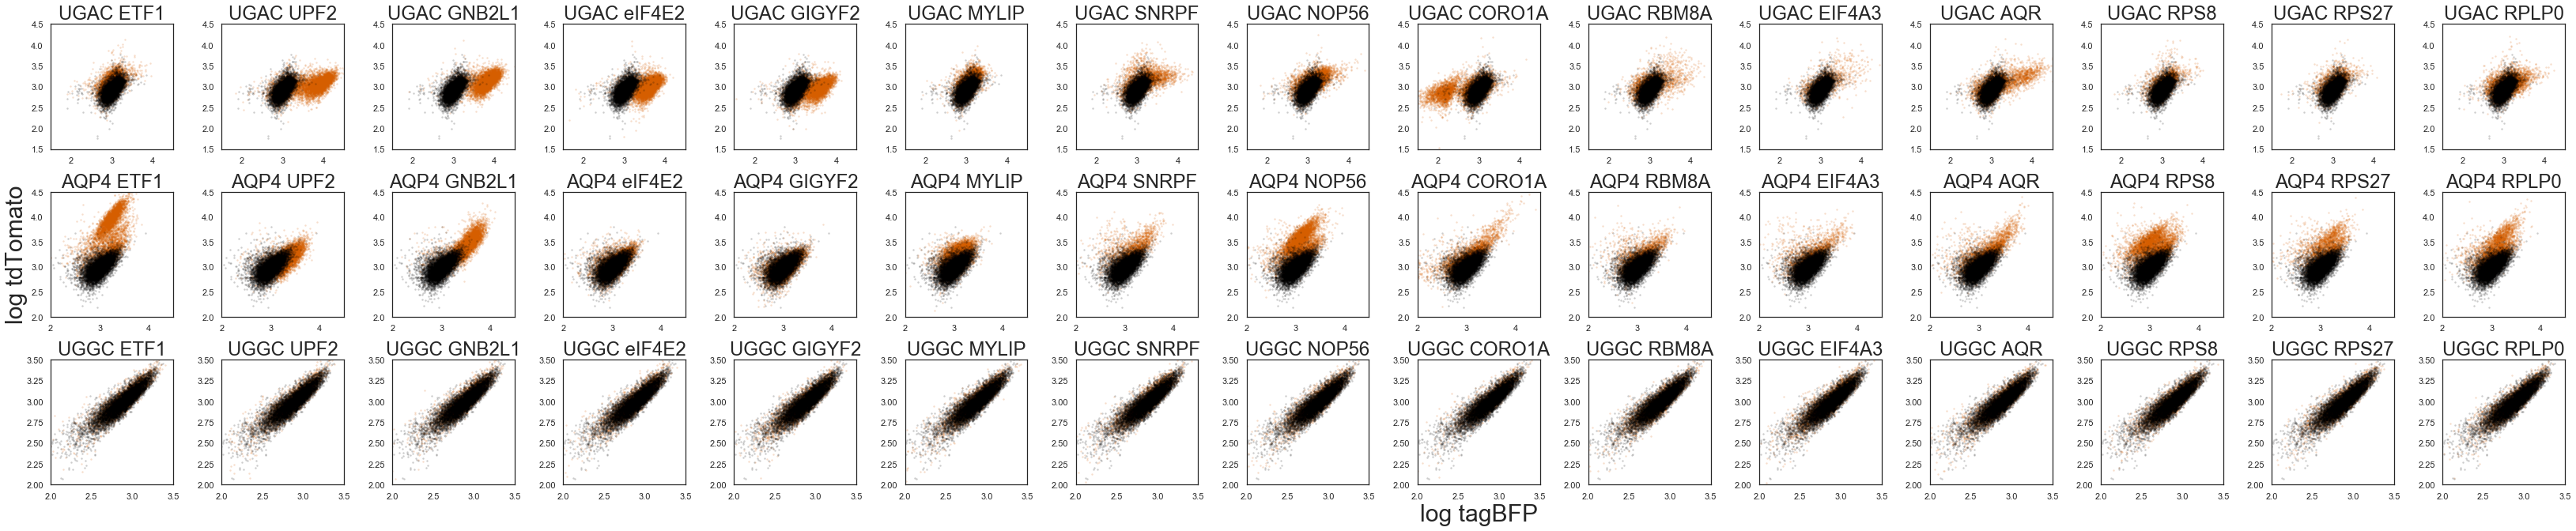

In [68]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 15
num_plots_high = 3

x_var='log tagBFP'
y_var='log tdTomato'
plot_index =1
fig = plt.figure(figsize=(3*num_plots_wide, 3*num_plots_high))
for stop_codon in stop_codons:
    for gene in genes[2:-1]:
            plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
            plots.append(plot)
            nt1_data = grouped_data.get_group((stop_codon, 'NT1'))
            guide_data = grouped_data.get_group((stop_codon, gene))
            guide_data.plot.scatter(x=x_var,y=y_var, color=vermillion, alpha=0.2, ax=plot, lw=0, s=6)
            nt1_data.plot.scatter(x=x_var, y=y_var, color=black, alpha=0.2, ax=plot, lw=0, s=6)
            plot_index += 1
            plot.set_title('%s %s'% (stop_codon, gene), fontsize=24)
            plot.set_xlabel(x_var)
            plot.set_ylabel(y_var)
            if stop_codon == 'UGAC':
                plot.set_xlim(1.5, 4.5)
                plot.set_ylim(1.5, 4.5)
            elif stop_codon == 'AQP4':
                plot.set_xlim(2, 4.5)
                plot.set_ylim(2, 4.5)
            elif stop_codon == 'UGGC':
                plot.set_xlim(2, 3.5)
                plot.set_ylim(2, 3.5)
            plot.set_xlabel('', fontsize=1)
            plot.set_ylabel('', fontsize=1)
plt.tight_layout()
plots[38].set_xlabel(x_var, fontsize=30)
plots[15].set_ylabel(y_var, fontsize=30)
plt.savefig('20190607_scatter.pdf', transparent=True)
plt.savefig('20190607_scatter.png', transparent=True)

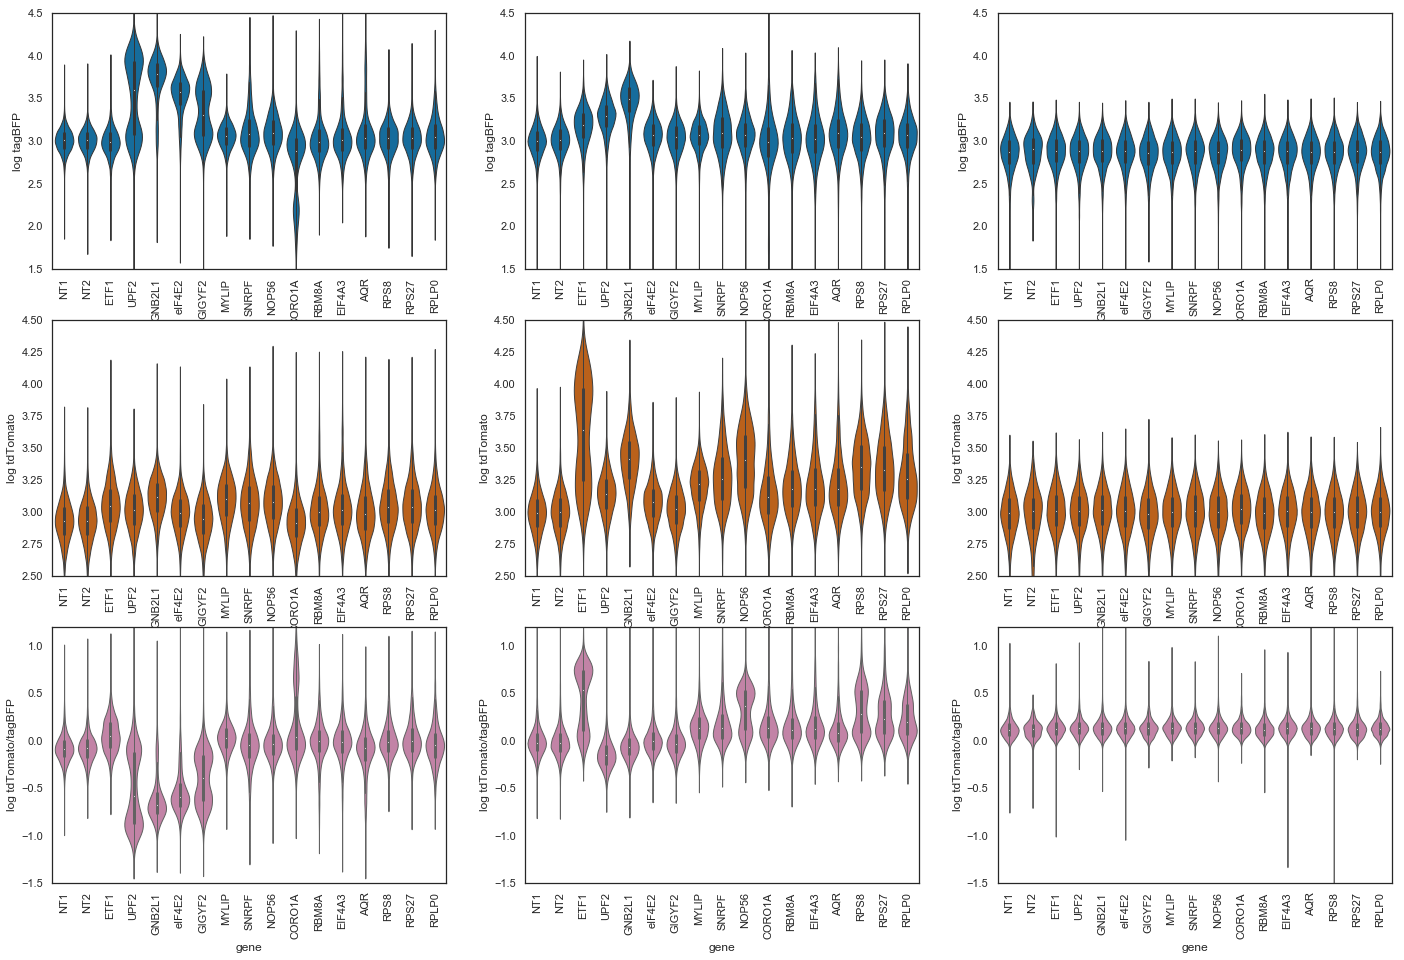

In [94]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)

#grouped_data = all_data.groupby(['stop codon', 'gene'])
sample_data=all_data[all_data['gene']!='untreated']
fig, ax = plt.subplots(3,3, figsize=(24, 16), sharey=False)
sns.violinplot(x="gene", y="log tagBFP", scale='width', data=sample_data[sample_data['stop codon']=='UGAC'], ax=ax[0][0], linewidth=1, color=blue, fontsize=25)
sns.violinplot(x="gene", y="log tdTomato", scale='width', data=sample_data[sample_data['stop codon']=='UGAC'], ax=ax[1][0], linewidth=1, color=vermillion)
sns.violinplot(x="gene", y="log tdTomato/tagBFP", scale='width', data=sample_data[sample_data['stop codon']=='UGAC'], ax=ax[2][0], linewidth=1, color=reddishPurple)
sns.violinplot(x="gene", y="log tagBFP", scale='width', data=sample_data[sample_data['stop codon']=='AQP4'], ax=ax[0][1], linewidth=1, color=blue)
sns.violinplot(x="gene", y="log tdTomato", scale='width', data=sample_data[sample_data['stop codon']=='AQP4'], ax=ax[1][1], linewidth=1, color=vermillion)
sns.violinplot(x="gene", y="log tdTomato/tagBFP", scale='width', data=sample_data[sample_data['stop codon']=='AQP4'].replace([np.inf, -np.inf], np.nan).dropna(), ax=ax[2][1], linewidth=1, color=reddishPurple)
sns.violinplot(x="gene", y="log tagBFP", scale='width', data=sample_data[sample_data['stop codon']=='UGGC'], ax=ax[0][2], linewidth=1, color=blue)
sns.violinplot(x="gene", y="log tdTomato", scale='width', data=sample_data[sample_data['stop codon']=='UGGC'], ax=ax[1][2], linewidth=1, color=vermillion)
sns.violinplot(x="gene", y="log tdTomato/tagBFP", scale='width', data=sample_data[sample_data['stop codon']=='UGGC'].replace([np.inf, -np.inf], np.nan).dropna(), ax=ax[2][2], linewidth=1, color=reddishPurple)

ax[0][0].set_ylim(1.5,4.5)
ax[0][1].set_ylim(1.5,4.5)
ax[0][2].set_ylim(1.5,4.5)
ax[1][0].set_ylim(2.5,4.5)
ax[1][1].set_ylim(2.5,4.5)
ax[1][2].set_ylim(2.5,4.5)
ax[2][0].set_ylim(-1.5,1.2)
ax[2][1].set_ylim(-1.5,1.2)
ax[2][2].set_ylim(-1.5,1.2)
for axis1 in ax:
    for axis in axis1:
        for label in axis.get_xticklabels():
            label.set_rotation(90)
plt.savefig('20190607_violin.pdf', transparent=True)

In [28]:
from numpy import exp, loadtxt, pi, sqrt

from lmfit import Model

#define 2-gaussian function
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))
'''
def double_gaussian(x, amp1, cen1, wid1, amp2, cen2, wid2, frac2):
    '''
    need amplitudes and widths for 2 gaussians
    and fraction of cells (from 0.0 to 1.0) that are in second gaussian
    '''
    
    return (1-frac2)*gaussian(x, amp1, cen1, wid1) + (frac2)*gaussian(x, amp2, cen2, wid2)
'''

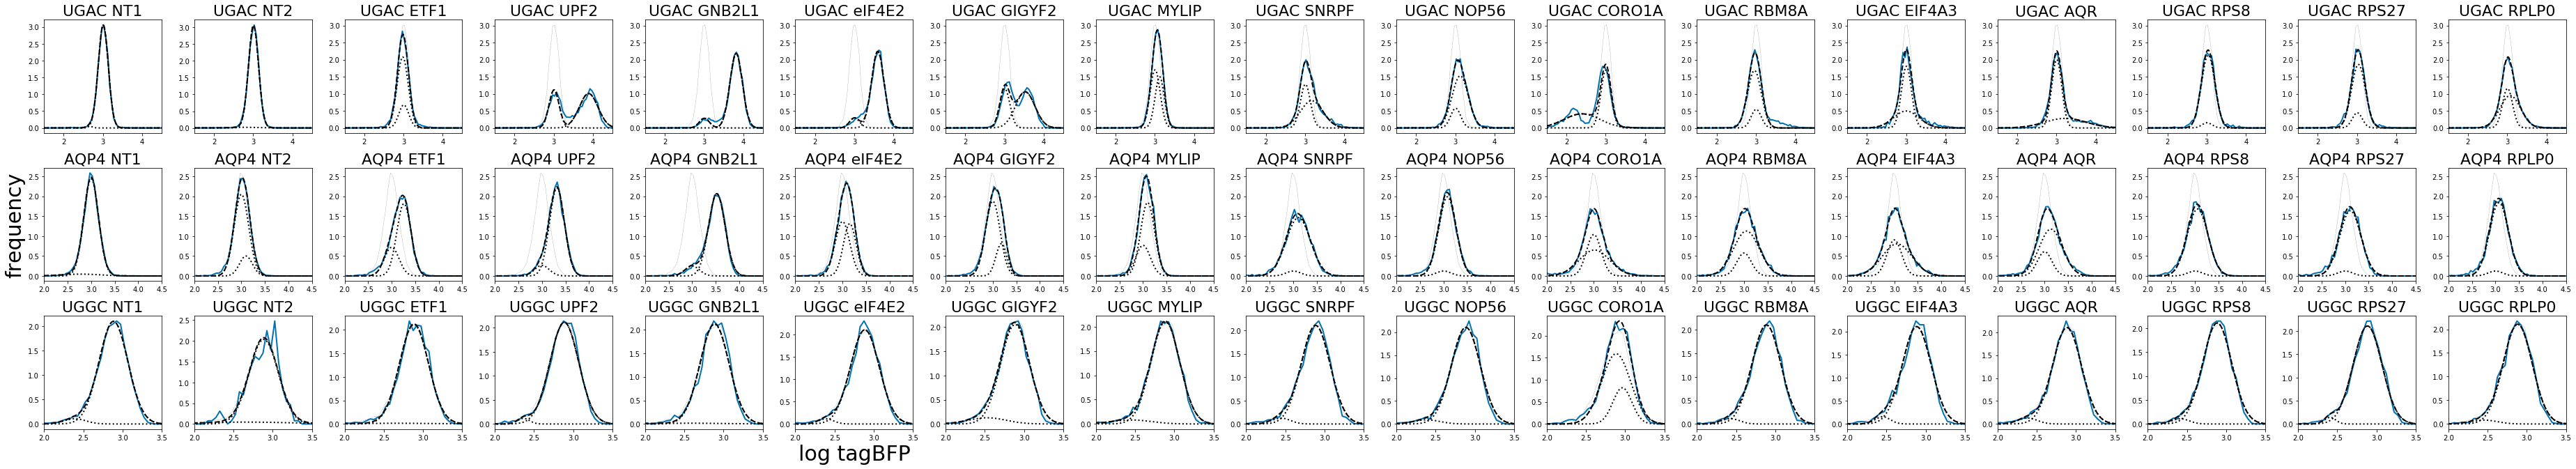

In [64]:
#try 2-component fits for these histograms to figure out what fraction are affected

'''
# <examples/doc_model_gaussian.py>
import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt

from lmfit import Model

data = loadtxt('model1d_gauss.dat')
x = data[:, 0]
y = data[:, 1]


def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=5, cen=5, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()

'''

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from scipy.optimize import curve_fit

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 17
num_plots_high = 3

x_var='log tagBFP'
#y_var='tdTomato-A'
plot_index =1
fig = plt.figure(figsize=(3*num_plots_wide, 3*num_plots_high))

outfile = open('20190618_fitting_stats_logtagBFP.tsv', 'w')

outfile.write('sample\tguide_amplitude\tmedian_nt1\tmedian_guide\twidth_guide\tfraction_guide\tguide_integral/total_integral\n')
for stop_codon in stop_codons:
    for gene in genes[0:-1]:
        plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
        plots.append(plot)
        nt1_data = grouped_data.get_group((stop_codon, 'NT1'))
        nt1_hist, nt1_edges = np.histogram(nt1_data[x_var], bins=100, normed=True, range=(0., 5.))
        plot.plot(nt1_edges[:-1]+(nt1_edges[2]-nt1_edges[1])/2, nt1_hist, color=black, linestyle='--', alpha=0.6, lw=0.3)
        (amp_nt, cen_nt, wid_nt), covar = curve_fit(gaussian, nt1_edges[:-1]+(nt1_edges[2]-nt1_edges[1])/2, nt1_hist)
        
        
        def double_gaussian(x, amp_guide, cen_guide, wid_guide, frac_guide):
            '''
            need amplitudes and widths for 2 gaussians, first of which is defined by NT1
            and fraction of cells (from 0.0 to 1.0) that are in second gaussian
            '''

            return (1-frac_guide)*gaussian(x, amp_nt, cen_nt, wid_nt) + (frac_guide)*gaussian(x, amp_guide, cen_guide, wid_guide)
        
        #nt2_data[x_var].plot.hist(color=black, histtype='step', bins=100, normed=True, linestyle=':', alpha=0.6, ax=plot, lw=3)
        guide_data = grouped_data.get_group((stop_codon, gene))
        guide_hist, guide_edges = np.histogram(guide_data[x_var], bins=100, normed=True, range=(0., 5.))
        plot.plot(guide_edges[:-1]+(guide_edges[2]-guide_edges[1])/2, guide_hist, color=blue, linestyle='-', alpha=1.0, lw=2)
        p0 = [amp_nt, cen_nt, wid_nt, 0.0] #initial guess, will assume that half of the cells respond as initial guess
        (amp_guide, cen_guide, wid_guide, frac_guide), covar = curve_fit(double_gaussian, guide_edges[:-1]+(guide_edges[2]-guide_edges[1])/2, guide_hist, bounds=(0, [5, 5, 5, 0.95]), maxfev=10000)
        fit_x = np.arange(0,5,0.01)
        fit_y = [double_gaussian(x, amp_guide, cen_guide, wid_guide, frac_guide) for x in fit_x]
        guide_integral = sum([frac_guide*gaussian(x, amp_guide, cen_guide, wid_guide) for x in fit_x])
        total_integral = sum(fit_y)
        outfile.write('%s %s\t%f\t%f\t%f\t%f\t%f\t%f\n' % (stop_codon, gene, amp_guide, cen_nt, cen_guide, wid_guide, frac_guide, guide_integral/total_integral))
        plot.plot(fit_x, fit_y, color=black, linestyle='--', alpha=1.0, lw=2)
        plot.plot(fit_x, [(1-frac_guide)*gaussian(x, amp_nt, cen_nt, wid_nt) for x in fit_x], color=black, linestyle=':', alpha=1.0, lw=2)
        plot.plot(fit_x, [frac_guide*gaussian(x, amp_guide, cen_guide, wid_guide) for x in fit_x], color=black, linestyle=':', alpha=1.0, lw=2)
        plot.set_title('%s %s'% (stop_codon, gene), fontsize=22)
        plot.set_xlabel('', fontsize=1)
        plot.set_ylabel('', fontsize=1)
        #plot.set_ylabel(y_var)
        #lot.set_xlim(xmin, xmax)
        if stop_codon == 'UGAC':
            plot.set_xlim(1.5, 4.5)
        elif stop_codon == 'AQP4':
            plot.set_xlim(2, 4.5)
        elif stop_codon == 'UGGC':
            plot.set_xlim(2, 3.5)
        guide_index+=1
        plot_index += 1
plt.tight_layout()
plots[39].set_xlabel(x_var, fontsize=30)
plots[17].set_ylabel('frequency', fontsize=30)
plt.savefig('20190618_log_tagBFP_hist_fitting.pdf', transparent=True)
outfile.close()

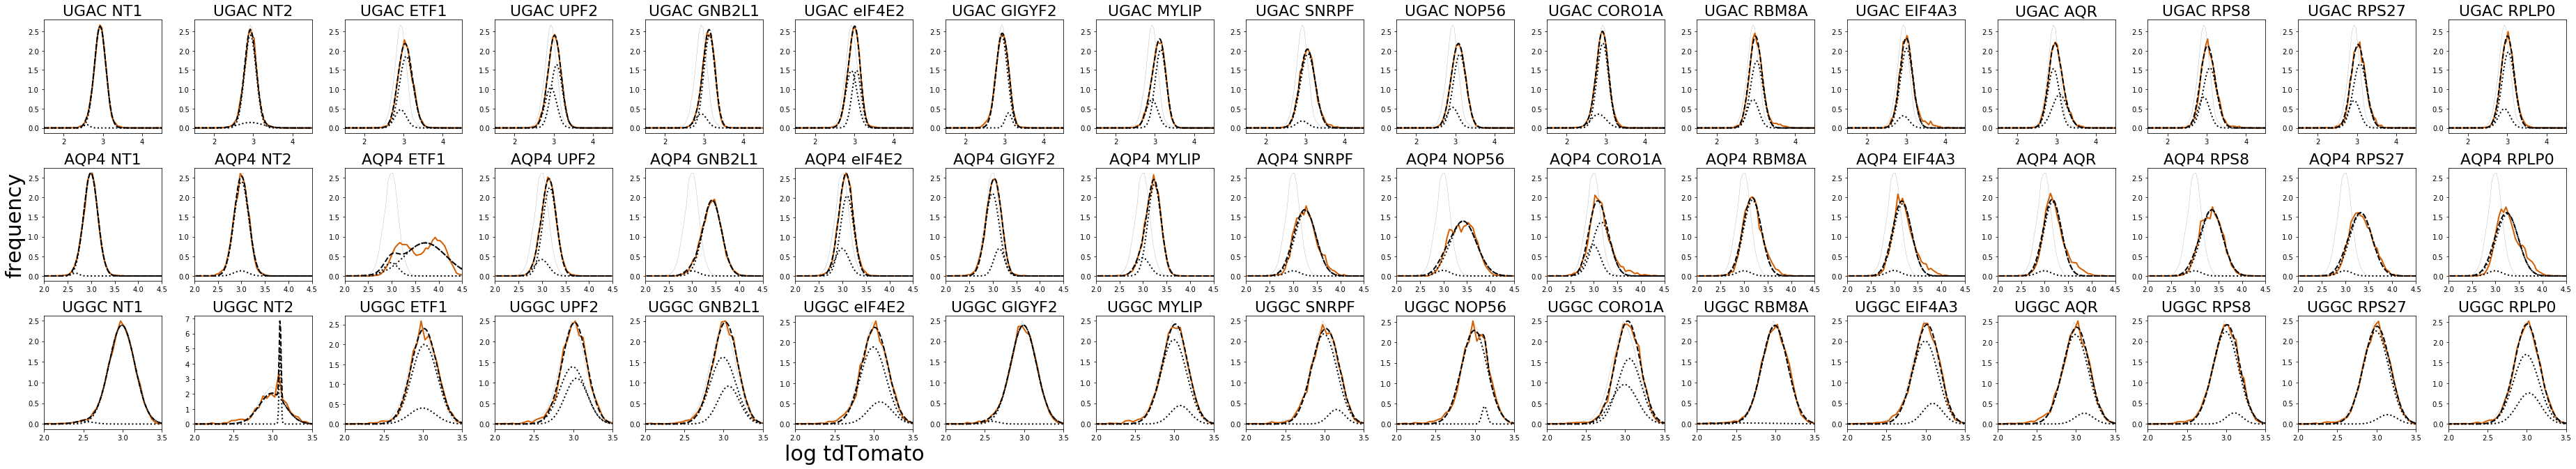

In [65]:
#try 2-component fits for these histograms to figure out what fraction are affected

'''
# <examples/doc_model_gaussian.py>
import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt

from lmfit import Model

data = loadtxt('model1d_gauss.dat')
x = data[:, 0]
y = data[:, 1]


def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=5, cen=5, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()

'''

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from scipy.optimize import curve_fit

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 17
num_plots_high = 3

x_var='log tdTomato'
#y_var='tdTomato-A'
plot_index =1
fig = plt.figure(figsize=(3*num_plots_wide, 3*num_plots_high))

outfile = open('20190618_fitting_stats_logtdTomato.tsv', 'w')

outfile.write('sample\tguide_amplitude\tmedian_nt1\tmedian_guide\twidth_guide\tfraction_guide\tguide_integral/total_integral\n')
for stop_codon in stop_codons:
    for gene in genes[0:-1]:
        plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
        plots.append(plot)
        nt1_data = grouped_data.get_group((stop_codon, 'NT1'))
        nt1_hist, nt1_edges = np.histogram(nt1_data[x_var], bins=100, normed=True, range=(0., 5.))
        plot.plot(nt1_edges[:-1]+(nt1_edges[2]-nt1_edges[1])/2, nt1_hist, color=black, linestyle='--', alpha=0.6, lw=0.3)
        (amp_nt, cen_nt, wid_nt), covar = curve_fit(gaussian, nt1_edges[:-1]+(nt1_edges[2]-nt1_edges[1])/2, nt1_hist)
        
        
        def double_gaussian(x, amp_guide, cen_guide, wid_guide, frac_guide):
            '''
            need amplitudes and widths for 2 gaussians, first of which is defined by NT1
            and fraction of cells (from 0.0 to 1.0) that are in second gaussian
            '''

            return (1-frac_guide)*gaussian(x, amp_nt, cen_nt, wid_nt) + (frac_guide)*gaussian(x, amp_guide, cen_guide, wid_guide)
        
        #nt2_data[x_var].plot.hist(color=black, histtype='step', bins=100, normed=True, linestyle=':', alpha=0.6, ax=plot, lw=3)
        guide_data = grouped_data.get_group((stop_codon, gene))
        guide_hist, guide_edges = np.histogram(guide_data[x_var], bins=100, normed=True, range=(0., 5.))
        plot.plot(guide_edges[:-1]+(guide_edges[2]-guide_edges[1])/2, guide_hist, color=vermillion, linestyle='-', alpha=1.0, lw=2)
        p0 = [amp_nt, cen_nt, wid_nt, 0.0] #initial guess, will assume that half of the cells respond as initial guess
        (amp_guide, cen_guide, wid_guide, frac_guide), covar = curve_fit(double_gaussian, guide_edges[:-1]+(guide_edges[2]-guide_edges[1])/2, guide_hist, bounds=(0, [5, 5, 5, 0.95]), maxfev=10000)
        fit_x = np.arange(0,5,0.01)
        fit_y = [double_gaussian(x, amp_guide, cen_guide, wid_guide, frac_guide) for x in fit_x]
        guide_integral = sum([frac_guide*gaussian(x, amp_guide, cen_guide, wid_guide) for x in fit_x])
        total_integral = sum(fit_y)
        outfile.write('%s %s\t%f\t%f\t%f\t%f\t%f\t%f\n' % (stop_codon, gene, amp_guide, cen_nt, cen_guide, wid_guide, frac_guide, guide_integral/total_integral))
        plot.plot(fit_x, fit_y, color=black, linestyle='--', alpha=1.0, lw=2)
        plot.plot(fit_x, [(1-frac_guide)*gaussian(x, amp_nt, cen_nt, wid_nt) for x in fit_x], color=black, linestyle=':', alpha=1.0, lw=2)
        plot.plot(fit_x, [frac_guide*gaussian(x, amp_guide, cen_guide, wid_guide) for x in fit_x], color=black, linestyle=':', alpha=1.0, lw=2)
        plot.set_title('%s %s'% (stop_codon, gene), fontsize=22)
        plot.set_xlabel('', fontsize=1)
        plot.set_ylabel('', fontsize=1)
        #plot.set_ylabel(y_var)
        #lot.set_xlim(xmin, xmax)
        if stop_codon == 'UGAC':
            plot.set_xlim(1.5, 4.5)
        elif stop_codon == 'AQP4':
            plot.set_xlim(2, 4.5)
        elif stop_codon == 'UGGC':
            plot.set_xlim(2, 3.5)
        guide_index+=1
        plot_index += 1
plt.tight_layout()
plots[39].set_xlabel(x_var, fontsize=30)
plots[17].set_ylabel('frequency', fontsize=30)
plt.savefig('20190618_log_tdTomato_hist_fitting.pdf', transparent=True)
outfile.close()

## 20190625 - Make some example scatterplots of ETF1Δ and UPF2Δ for talks

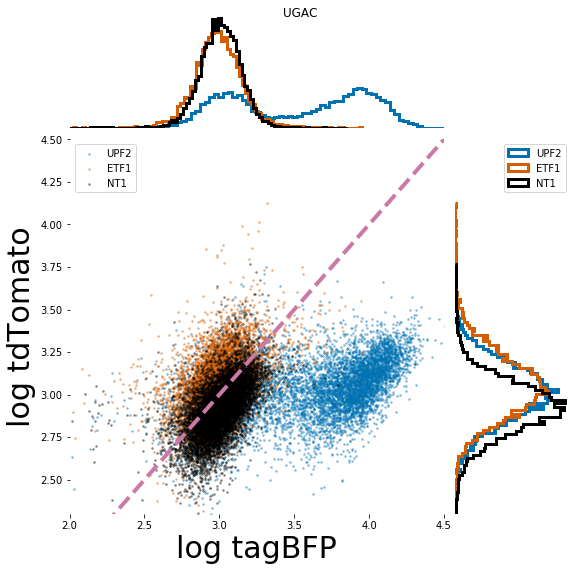

In [91]:
%matplotlib inline
import warnings
import matplotlib as mpl

warnings.filterwarnings("ignore")
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from matplotlib.ticker import NullFormatter

plotting_stop_codons = ['UGAC']
plotting_guides = ['UPF2', 'ETF1', 'NT1', ]


nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

axes = [axScatter, axHistx, axHisty]
hist_axes = [axHistx, axHisty]

x_var='log tagBFP'
y_var='log tdTomato'

colors=[blue, vermillion, black]
color_index=0
for stop_codon in plotting_stop_codons:
    for guide in plotting_guides:
        data = grouped_data.get_group((stop_codon, guide))
        data.plot.scatter(x=x_var,y=y_var, color=colors[color_index], alpha=0.5, ax=axScatter, lw=0, s=6, label = guide)
        data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=colors[color_index], alpha=1, ax=axHistx, lw=3, label = guide)
        data[y_var].plot.hist(histtype='step', bins=100, normed=True, color=colors[color_index], alpha=1, ax=axHisty, lw=3, orientation='horizontal', label = guide)
        color_index+=1
axScatter.plot(np.arange(0,6), lw=4, color=reddishPurple, ls='--')

for axis in axes:
    for dir in axis.spines:
        axis.spines[dir].set_visible(False)
for axis in hist_axes:
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.set_ylabel('')
    axis.set_xlabel('')

axScatter.set_xlabel(x_var, fontsize=30)
axScatter.set_ylabel(y_var, fontsize=30)
axScatter.set_xlim(2, 4.5)
axScatter.set_ylim(2.3, 4.5)
axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())
plt.suptitle(stop_codon)
plt.legend()
plt.savefig('E4.036_20190625_UGAC_ETF1_UPF2_log_line.pdf', transparent=True)
#plt.savefig('E4.036_20190624_compare_contexts_log.pdf', transparent=True)

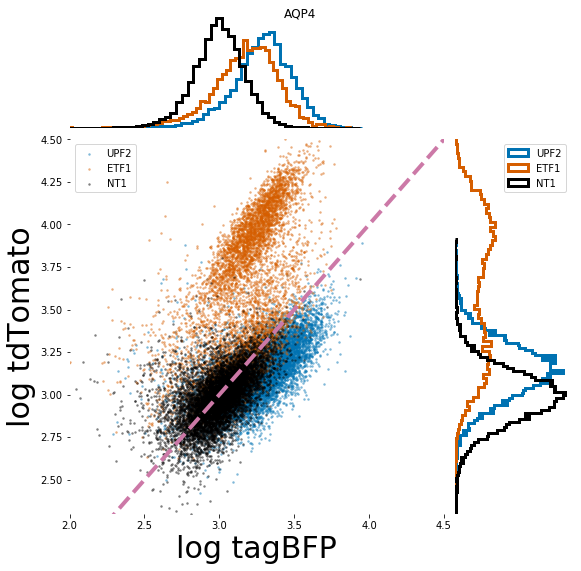

In [92]:
%matplotlib inline
import warnings
import matplotlib as mpl

warnings.filterwarnings("ignore")
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from matplotlib.ticker import NullFormatter

plotting_stop_codons = ['AQP4']
plotting_guides = ['UPF2', 'ETF1', 'NT1']


nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

axes = [axScatter, axHistx, axHisty]
hist_axes = [axHistx, axHisty]

x_var='log tagBFP'
y_var='log tdTomato'

colors=[blue, vermillion, black]
color_index=0
for stop_codon in plotting_stop_codons:
    for guide in plotting_guides:
        data = grouped_data.get_group((stop_codon, guide))
        data.plot.scatter(x=x_var,y=y_var, color=colors[color_index], alpha=0.5, ax=axScatter, lw=0, s=6, label = guide)
        data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=colors[color_index], alpha=1, ax=axHistx, lw=3, label = guide)
        data[y_var].plot.hist(histtype='step', bins=100, normed=True, color=colors[color_index], alpha=1, ax=axHisty, lw=3, orientation='horizontal', label = guide)
        
        color_index+=1
axScatter.plot(np.arange(0,6), lw=4, color=reddishPurple, ls='--')

for axis in axes:
    for dir in axis.spines:
        axis.spines[dir].set_visible(False)
for axis in hist_axes:
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.set_ylabel('')
    axis.set_xlabel('')

axScatter.set_xlabel(x_var, fontsize=30)
axScatter.set_ylabel(y_var, fontsize=30)
axScatter.set_xlim(2, 4.5)
axScatter.set_ylim(2.3, 4.5)
axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())
plt.suptitle(stop_codon)
plt.legend()
plt.savefig('E4.036_20190625_AQP4_ETF1_UPF2_log_line.pdf', transparent=True)


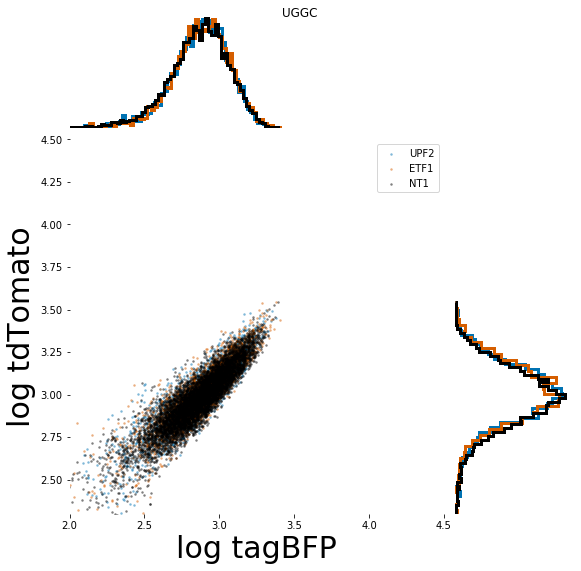

In [124]:
%matplotlib inline
import warnings
import matplotlib as mpl

warnings.filterwarnings("ignore")
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from matplotlib.ticker import NullFormatter

plotting_stop_codons = ['UGGC']
plotting_guides = ['UPF2', 'ETF1', 'NT1']


nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

axes = [axScatter, axHistx, axHisty]
hist_axes = [axHistx, axHisty]

x_var='log tagBFP'
y_var='log tdTomato'

colors=[blue, vermillion, black]
color_index=0
for stop_codon in plotting_stop_codons:
    for guide in plotting_guides:
        data = grouped_data.get_group((stop_codon, guide))
        data.plot.scatter(x=x_var,y=y_var, color=colors[color_index], alpha=0.5, ax=axScatter, lw=0, s=6, label = guide)
        data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=colors[color_index], alpha=1, ax=axHistx, lw=3, label = guide)
        data[y_var].plot.hist(histtype='step', bins=100, normed=True, color=colors[color_index], alpha=1, ax=axHisty, lw=3, orientation='horizontal', label = guide)
        
        color_index+=1
#axScatter.plot(np.arange(0,6), lw=4, color=reddishPurple, ls='--')

for axis in axes:
    for dir in axis.spines:
        axis.spines[dir].set_visible(False)
for axis in hist_axes:
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.set_ylabel('')
    axis.set_xlabel('')

axScatter.set_xlabel(x_var, fontsize=30)
axScatter.set_ylabel(y_var, fontsize=30)
axScatter.set_xlim(2, 4.5)
axScatter.set_ylim(2.3, 4.5)
axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())
plt.suptitle(stop_codon)
#plt.legend()
plt.savefig('E4.062_20190625_UGGC_ETF1_UPF2_log.pdf', transparent=True)
#plt.savefig('E4.036_20190624_compare_contexts_log.pdf', transparent=True)

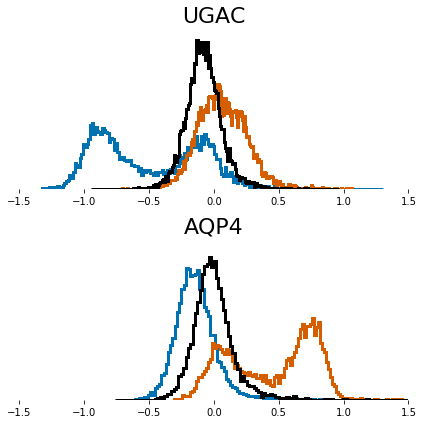

In [120]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 1
num_plots_high = 2

x_var='log tdTomato/tagBFP'
#y_var='tdTomato-A'
plot_index =1
fig = plt.figure(figsize=(6*num_plots_wide, 3*num_plots_high))

plotting_stop_codons = ['UGAC', 'AQP4']
plotting_guides = ['UPF2', 'ETF1', 'NT1']
colors=[blue, vermillion, black]

for stop_codon in plotting_stop_codons:
    color_index = 0
    for guide in plotting_guides:
        plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
        plots.append(plot)
        guide_data = grouped_data.get_group((stop_codon, guide)).replace([np.inf, -np.inf], np.nan).dropna()
        guide_data[x_var].plot.hist(histtype='step', bins=200, normed=True, color=colors[color_index], alpha=1, ax=plot, lw=3, label=guide)
        plot.set_title('%s'% (stop_codon), fontsize=22)
        plot.set_xlabel('', fontsize=1)
        plot.set_ylabel('', fontsize=1)
        #plot.set_ylabel(y_var)
        #lot.set_xlim(xmin, xmax)
        #if stop_codon == 'UGAC':
        plot.set_xlim(-1.5, 1.5)
        plot.set_ylim(0, 3.7)
        #elif stop_codon == 'AQP4':
        #    plot.set_xlim(-1.5, 1.5)
        #elif stop_codon == 'UGGC':
        #    plot.set_xlim(-1.5, 1.5)
        color_index += 1
    plot_index += 1
plt.tight_layout()
#plt.legend()
for plot in plots:
    for dir in plot.spines:
        plot.spines[dir].set_visible(False)
        plot.get_yaxis().set_ticks([])

#plots[2].set_xlabel(x_var, fontsize=30)
plt.savefig('E4.036_20190625_UGAC_AQP4_ETF1_UPF2_log_ratio_hists.pdf', transparent=True)

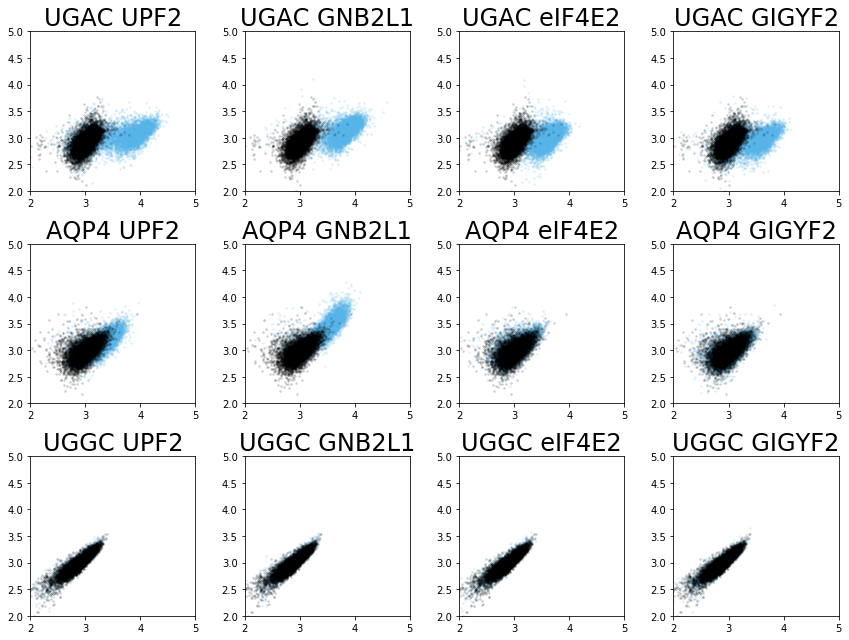

In [130]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 4
num_plots_high = 3

x_var='log tagBFP'
y_var='log tdTomato'
plot_index =1
fig = plt.figure(figsize=(3*num_plots_wide, 3*num_plots_high))
for stop_codon in stop_codons:
    for gene in genes[3:7]:
            plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
            plots.append(plot)
            nt1_data = grouped_data.get_group((stop_codon, 'NT1'))
            guide_data = grouped_data.get_group((stop_codon, gene))
            guide_data.plot.scatter(x=x_var,y=y_var, color=skyBlue, alpha=0.2, ax=plot, lw=0, s=6)
            nt1_data.plot.scatter(x=x_var, y=y_var, color=black, alpha=0.2, ax=plot, lw=0, s=6)
            plot_index += 1
            plot.set_title('%s %s'% (stop_codon, gene), fontsize=24)
            plot.set_xlabel(x_var)
            plot.set_ylabel(y_var)
            if stop_codon == 'UGAC':
                plot.set_xlim(2, 5)
                plot.set_ylim(2, 5)
            elif stop_codon == 'AQP4':
                plot.set_xlim(2, 5)
                plot.set_ylim(2, 5)
            elif stop_codon == 'UGGC':
                plot.set_xlim(2, 5)
                plot.set_ylim(2, 5)
            plot.set_xlabel('', fontsize=1)
            plot.set_ylabel('', fontsize=1)
plt.tight_layout()
#plots[38].set_xlabel(x_var, fontsize=30)
#plots[15].set_ylabel(y_var, fontsize=30)
plt.savefig('4.062_UPF2_RACK1_GIGY_4EHP_20190626_scatter.pdf', transparent=True)
plt.savefig('4.062_UPF2_RACK1_GIGY_4EHP_20190626_scatter.png', transparent=True)

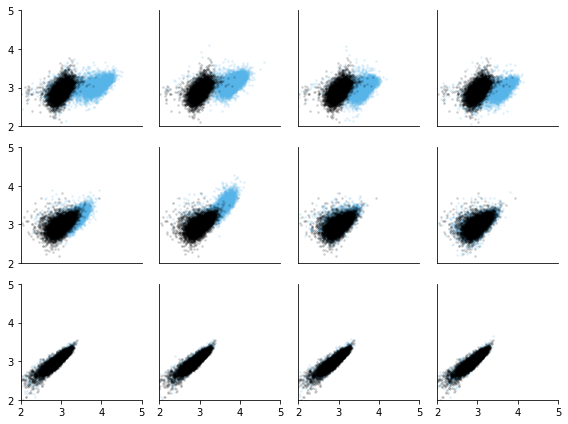

In [136]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 4
num_plots_high = 3

x_var='log tagBFP'
y_var='log tdTomato'
plot_index =1
fig = plt.figure(figsize=(2*num_plots_wide, 2*num_plots_high))
for stop_codon in stop_codons:
    for gene in genes[3:7]:
            plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
            plots.append(plot)
            nt1_data = grouped_data.get_group((stop_codon, 'NT1'))
            guide_data = grouped_data.get_group((stop_codon, gene))
            guide_data.plot.scatter(x=x_var,y=y_var, color=skyBlue, alpha=0.2, ax=plot, lw=0, s=6)
            nt1_data.plot.scatter(x=x_var, y=y_var, color=black, alpha=0.2, ax=plot, lw=0, s=6)
            #plot.set_title('%s %s'% (stop_codon, gene), fontsize=24)
            plot.set_xlabel(x_var)
            plot.set_ylabel(y_var)
            if stop_codon == 'UGAC':
                plot.set_xlim(2, 5)
                plot.set_ylim(2, 5)
            elif stop_codon == 'AQP4':
                plot.set_xlim(2, 5)
                plot.set_ylim(2, 5)
            elif stop_codon == 'UGGC':
                plot.set_xlim(2, 5)
                plot.set_ylim(2, 5)
            plot.set_xlabel('', fontsize=1)
            plot.set_ylabel('', fontsize=1)
            if plot_index not in [1,5,9]:
                plot.set_yticks([])
            if plot_index not in range(9,13):
                plot.set_xticks([])
            plot.spines['top'].set_visible(False)
            plot.spines['right'].set_visible(False)
            plot_index += 1

plt.tight_layout()
#plots[38].set_xlabel(x_var, fontsize=30)
#plots[15].set_ylabel(y_var, fontsize=30)
plt.savefig('4.062_UPF2_RACK1_GIGY_4EHP_20190626_scatter_no_title.pdf', transparent=True)
plt.savefig('4.062_UPF2_RACK1_GIGY_4EHP_20190626_scatter_no_title.png', transparent=True, dpi=500)

### Output linear means to compare to mRNA levels

In [138]:
outfile = open('20190626_linear_summary_tagBFP_tdTomato.tsv', 'w')

outfile.write('sample\tmean tagBFP\tstd tagBFP\tmean tdTomato\tstd tdTomato\n')
for stop_codon in stop_codons:
    for gene in genes[0:-1]:
        guide_data = grouped_data.get_group((stop_codon, gene))
        outfile.write('%s %s\t%f\t%f\t%f\t%f\n' % (stop_codon, gene, np.mean(guide_data['tagBFP-A']), np.std(guide_data['tagBFP-A']), np.mean(guide_data['tdTomato-A']), np.std(guide_data['tdTomato-A'])))
outfile.close()